<h1>Sumário<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependências" data-toc-modified-id="Dependências-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependências</a></span></li><li><span><a href="#Funções-auxiliares" data-toc-modified-id="Funções-auxiliares-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Funções auxiliares</a></span></li><li><span><a href="#Pré-processamento" data-toc-modified-id="Pré-processamento-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pré-processamento</a></span></li><li><span><a href="#Processamento" data-toc-modified-id="Processamento-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Processamento</a></span></li><li><span><a href="#Visualização" data-toc-modified-id="Visualização-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualização</a></span></li><li><span><a href="#Conclusões" data-toc-modified-id="Conclusões-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusões</a></span></li></ul></div>

### Dependências

O motivo da escolha da biblioteca `imageio` ao invés da biblioteca sugerida (`mahotas`) é apenas uma questão de portabilidade.

A semente de aleatoriedade é definida de modo global, para assegurar consistência.

In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
np.random.seed(42)

### Funções auxiliares
* `plot_image`: plota uma imagem na tela, com título e seu tamanho de bytes.

In [2]:
def plot_image(name, image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)
    
    tmp_fn = str(np.random.random())+'.jpg'
    imageio.imwrite(tmp_fn, image)
    byte_cnt = os.path.getsize(tmp_fn)
    os.remove(tmp_fn)
    
    ax.text(0.5, -0.06, f'{byte_cnt} bytes', horizontalalignment='center', transform=ax.transAxes)

### Pré-processamento

Ao carregar a imagem, o valor da cor de cada pixel é uma variável do tipo `uint8`.

Durante a aplicação do algoritmo `KMeans` no decorrer deste _notebook_, é extremamente provável que as cores escolhidas pelo algorítmo (centróides) sejam do tipo `float64`, então precisaremos nos atentar a isso e realizar a conversão para `uint8` quando necessário.

In [3]:
original_name = 'spectrum' # 'anakin'
path = f'original_images/{original_name}.jpg'
original_image = imageio.imread(path)

In [4]:
original_image.dtype

dtype('uint8')

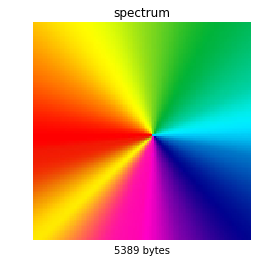

In [5]:
plot_image(original_name, original_image)

Um vetor de pixels se mostra extremamente conveniente, facilitando tanto na contagem de pixels distintos, quanto na utilização do algoritmo de clusterização, uma vez que o `KMeans` reconhecerá o vetor de pixels como uma estrutura simlar à um `DataFrame` (da biblioteca `pandas`), onde cada pixel é um exemplo no dataset e cada cor do pixel (_Red_, _Green_ e _Blue_) é um atributo.

In [6]:
height, width, depth = original_image.shape
pixels = original_image.reshape(
    height*width, depth)
pixels

Image([[255, 197,   0],
       [255, 198,   0],
       [255, 200,   1],
       ..., 
       [  1,   2, 142],
       [  1,   4, 143],
       [  1,   4, 143]], dtype=uint8)

In [7]:
unique_pixels = np.unique(pixels, axis=0)
partial_palette = int(0.75*len(unique_pixels))
palettes = [16, 32, 64, partial_palette]
palettes

[16, 32, 64, 3905]

### Processamento

Definimos a quantidade de iterações máximas do algoritmo `KMeans` como $20$, pois observando através de alguns testes, notamos que as iterações só ultrapassam este valor quando a quantidade de clusters/cores é muito alta (geralmente maior que $1000$). Neste caso, sacrificamos um pouco da qualidade da clusterização em troca de uma aceleração no processamento.

In [8]:
names = []
images = []
for k in palettes:
    kmeans = KMeans(k, max_iter=20).fit(pixels)
    
    labels = kmeans.predict(pixels)
    palette = kmeans.cluster_centers_.astype('uint8')
    
    name = f'{original_name} with {k} colors'
    new_image = palette[labels].reshape(
        width, height, depth)
    
    names.append(name)
    images.append(new_image)
    
names.append(f'{original_name} original')
images.append(original_image)

In [9]:
for name, image in zip(names, images):
    filename = f'modified_images/{name}.jpg'
    imageio.imsave(filename, image)

### Visualização

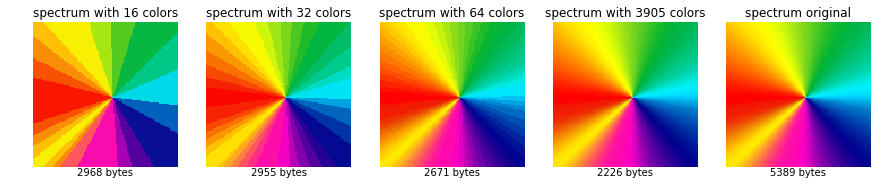

In [10]:
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(15, 20)
for name, image, ax in zip(names, images, axes):
    plot_image(name, image, ax)

### Conclusões

O algoritmo `KMeans`, apesar de conseguir definir um bom conjunto de $k$ cores para representar uma imagem, se mostra extremamente lento quando $k$ ou o tamanho do conjunto de dados ($altura*largura$, neste caso) é grande.

Outra conclusão é que a redução da quantidade de cores distintas em uma imagem não implica necessariamente na compreensão de seu tamanho em _bytes_.